<a href="https://colab.research.google.com/github/Ghazaleh99/Image_compression_mlp/blob/main/ANN_HW2_150901012_Hamzeh_IMC_standard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#HW2 - Neural Networks

##Image Compression using one hidden layer Neural Network



---



**Ghazaleh Hamzeh** 

**150901012**

In [ ]:
%pip install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 4.8 MB/s 


##Step 1 - Import the libraries

In [ ]:
# Package imports
# import cv2
import os
import patoolib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import math

##Step 2 - Setting up the Data

### Step 2.0 - Decompressing the .rar file

In [ ]:
patoolib.extract_archive("TestSet-ImageCompression.rar")
patoolib.extract_archive("TrainSet-ImageCompression.rar")

patool: Extracting TestSet-ImageCompression.rar ...
patool: running /usr/bin/unrar x -- /content/TestSet-ImageCompression.rar
patool:     with cwd='./Unpack_sw5_6c3f'
patool: ... TestSet-ImageCompression.rar extracted to `TestSet'.
patool: Extracting TrainSet-ImageCompression.rar ...
patool: running /usr/bin/unrar x -- /content/TrainSet-ImageCompression.rar
patool:     with cwd='./Unpack_ctefaxfk'
patool: ... TrainSet-ImageCompression.rar extracted to `TrainSet'.


'TrainSet'

In [ ]:
def create_dataset(path):
  img_data_array=[]
  os.chdir(path)
  for file in os.listdir(): 
    image_path = f'{path}/{file}'
    img = mpimg.imread(image_path)
    image = img / 255.0
    img_data_array.append(image)
  return np.array(img_data_array)

### Step 2.1 - Train set and Test set

In [ ]:
path_train = "/content/TrainSet"
train_img_data = create_dataset(path_train)
print('train image 0:\n', train_img_data[0])

path_test = "/content/TestSet"
test_img_data = create_dataset(path_test)
print('test image 0:\n', test_img_data[0])

train image 0:
 [[0.25098039 0.24705882 0.24313725 ... 0.3254902  0.3254902  0.32156863]
 [0.25490196 0.25098039 0.24705882 ... 0.33333333 0.32941176 0.3254902 ]
 [0.25490196 0.25098039 0.25098039 ... 0.3372549  0.33333333 0.32941176]
 ...
 [0.86666667 0.88235294 0.90980392 ... 0.88627451 0.88627451 0.88627451]
 [0.89411765 0.89019608 0.87058824 ... 0.88235294 0.88235294 0.88235294]
 [0.88235294 0.88627451 0.88235294 ... 0.88235294 0.88627451 0.88627451]]
test image 0:
 [[0.24705882 0.24705882 0.27843137 ... 0.75686275 0.82352941 0.82745098]
 [0.23137255 0.24313725 0.28235294 ... 0.72941176 0.8        0.8       ]
 [0.19215686 0.21568627 0.2627451  ... 0.63529412 0.70588235 0.71372549]
 ...
 [0.25882353 0.24313725 0.20784314 ... 0.53333333 0.58823529 0.60392157]
 [0.28627451 0.26666667 0.22352941 ... 0.49803922 0.57254902 0.58431373]
 [0.29803922 0.27843137 0.23137255 ... 0.48627451 0.58431373 0.60392157]]


##Step 3 - 8*8 Blocks

In [ ]:
def image2blocks(image, block_size):
  number_of_tiles = (image.shape[0] ** 2) // (block_size ** 2)
  tiles = np.zeros((number_of_tiles, block_size ** 2))
  c = 0
  arr = np.zeros(image.shape)
  im_h, im_w = image.shape[:2]
  bl_h, bl_w = block_size, block_size
  for row in np.arange(im_h - bl_h + 1, step=bl_h):
    for col in np.arange(im_w - bl_w + 1, step=bl_w):
      arr = image[row:row+bl_h, col:col+bl_w]
      newarr = arr.flatten()
      tiles[c] = newarr
      c += 1
  return tiles

In [ ]:
def dataset2blocks(images, block_size):
  c = []
  for i in range(images.shape[0]):
    arr = image2blocks(images[i], block_size)
    c.append(arr)
  a = np.array(c)
  a = a.reshape((a.shape[0]*a.shape[1], a.shape[2]))
  return a

In [ ]:
train_set = dataset2blocks(train_img_data, 8)
print(train_img_data.shape)
print(train_set.shape)

(91, 256, 256)
(93184, 64)


In [ ]:
test_set = dataset2blocks(test_img_data, 8)
print(test_img_data.shape)
print(test_set.shape)

(5, 256, 256)
(5120, 64)


##Step 4 - Train 

### 4.1 - Sigmoid activation function

In [ ]:
def sigmoid(Z):
  s = 1/(1+np.exp(-Z))    
  return s

### 4.2 - RelU activation function

In [ ]:
def Relu(Z):
  return np.maximum(0,Z)

### 4.3 - RelU derivitive function

In [ ]:
def dRelu(x):
  x[x<=0] = 0
  x[x>0] = 1
  return x

### 4.4 - PSNR funtion

In [ ]:
def psnr(img1, img2):
  mse = np.mean((img1 - img2) ** 2)
  if mse == 0:
    return 100
  PIXEL_MAX = 255.0
  return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [ ]:
def avg_PSNR(img1, img2):
  avg_psnr = 0
  for i in range(img1.shape[0]):
    avg_psnr += psnr(img1[i], img2[i])
  return avg_psnr/img1.shape[0]

### 4.5 - Multi layer Perceptron class

In [ ]:
class NN_mlp():

  def __init__(self, name, X, Y):
    self.name = name
    self.X = X.T
    self.Y = Y.T

  def layer_sizes(self):
    self.n_x = self.X.shape[0]
    self.n_y = self.Y.shape[0]
    return (self.n_x, self.n_h, self.n_y)

  def initialize_hyper_parameters(self, n_h, alpha):
    self.learning_rate = alpha
    # self.momentum = mu
    self.n_h = n_h

  def initialize_parameters(self):
    W1 = np.random.randn(self.n_h, self.n_x) * 0.01
    b1 = np.zeros((self.n_h, 1))
    W2 = np.random.randn(self.n_y, self.n_h) * 0.01
    b2 = np.zeros((self.n_y, 1))

    parameters = {'W1' : W1,
                  'b1' : b1,
                  'W2' : W2,
                  'b2' : b2}   
    return parameters

  def forward_propagation(self, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    Z1 = np.dot(W1, self.X) + b1
    A1 = Relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    cache = {"Z1": Z1,
            "A1": A1,
            "Z2": Z2,
            "A2": A2}   
    return A2, cache

  def MSE_loss(self, A2):
    c = []
    for i in range(self.Y.shape[0]):
      squared_errors = (A2[i] - self.Y[i]) ** 2
      Loss = np.sum(squared_errors)
      c.append(Loss)
    return np.array(c)

  def backward_propagation(self, parameters, cache):
    m = self.X.shape[1] # number of examples
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]

    A1 = cache["A1"]
    A2 = cache["A2"]
    Z1 = cache["Z1"]

    dZ2 = A2 - self.Y # d_sigmoid(z2) - y
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) *(np.sum(dZ2, axis=1, keepdims=True)) 
    dZ1 = np.dot(W2.T, dZ2) * dRelu(A1)
    dW1 = (1/m) *(np.dot(dZ1, self.X.T))
    db1 = (1/m) *(np.sum(dZ1, axis=1, keepdims=True))
    
    grads = { "dW1": dW1,
              "db1": db1,
              "dW2": dW2,
              "db2": db2}
    return grads

  def update_parameters(self, parameters, grads):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]

    W1 = W1 - self.learning_rate * dW1
    b1 = b1 - self.learning_rate * db1
    W2 = W2 - self.learning_rate * dW2
    b2 = b2 - self.learning_rate * db2
    
    param = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2}
    return param

  def mlp_train_model(self, num_iterations):
    l_error = [('hidden layer:', self.n_h), ('learning rate:', self.learning_rate)]
    np.random.seed(5)
    self.layer_sizes()
    parameters = self.initialize_parameters()

    for i in range(num_iterations):
      A2, cache = self.forward_propagation(parameters)
      loss = self.MSE_loss(A2)
      grads = self.backward_propagation(parameters, cache)
      parameters = self.update_parameters(parameters, grads)  
      avg_psnr = avg_PSNR(A2, self.Y)
      l_error.append(avg_psnr)
      if i%10 == 0:
        print('Loss after iteration', i, ':', loss)
    print('Loss after iteration', num_iterations, ':', loss)
    return parameters, l_error

#### Train on Number of Neurons in hidden layers : 30

In [ ]:
a = NN_mlp('30 * 30', train_set, train_set)
a.initialize_hyper_parameters(30, 0.1)
a_parameters, a_l_loss = a.mlp_train_model(1000)

Loss after iteration 0 : [8775.81453639 8759.78191941 8810.90889594 8799.4774335  8809.56299999
 8795.42673425 8768.13942597 8783.15178129 8778.91120651 8785.86588809
 8831.26976855 8807.82235475 8821.13188536 8842.85543487 8802.2743029
 8779.11969569 8819.02669064 8827.42048793 8849.38679944 8851.12886382
 8846.2684943  8842.95419863 8817.70527241 8836.5694348  8811.22053757
 8808.81669087 8861.02015751 8838.62859312 8853.14819956 8854.24424322
 8814.00749347 8849.17725143 8822.09506594 8824.40186847 8855.70960192
 8851.35695233 8880.91313169 8884.22378639 8825.87480775 8823.67165084
 8800.44646405 8811.47666129 8853.07120127 8855.97105346 8841.21995706
 8851.75074706 8808.07672704 8815.90109499 8763.49835743 8749.98335148
 8809.018472   8802.75495396 8807.91581089 8822.58445402 8756.77282277
 8772.16435101 8778.66301024 8767.81991272 8799.22148901 8788.12949133
 8787.26510233 8808.46766606 8764.25193824 8794.25926109]
Loss after iteration 10 : [8032.65782903 7857.28846122 7920.977747

#### Train on Number of Neurons in hidden layers : 20

In [ ]:
b = NN_mlp('20 * 20', train_set, train_set)
b.initialize_hyper_parameters(20, 0.1)
b_parameters, b_l_loss = b.mlp_train_model(1000)

Loss after iteration 0 : [8756.09018194 8755.05081002 8796.09352698 8802.49205714 8792.20297762
 8807.14018494 8778.50566582 8774.93273162 8767.21450018 8770.25342579
 8821.22420028 8818.72684358 8830.83018092 8845.41165731 8760.89827298
 8764.46386868 8824.41421891 8808.90037467 8859.45494896 8856.3989134
 8862.48335597 8863.96665377 8824.47537768 8841.51343072 8821.82676998
 8820.94651117 8863.19609729 8847.31644173 8852.89927574 8842.23257772
 8830.10817735 8821.56871233 8830.53564328 8848.00980829 8859.7371232
 8871.7654983  8860.85169665 8882.44582619 8839.34153137 8834.87981619
 8795.6769174  8808.58601647 8860.68780215 8852.57147109 8859.77181997
 8839.70955561 8807.44614454 8816.86086736 8774.5112575  8762.50019549
 8818.75450922 8802.42680403 8812.41531179 8832.26112341 8774.4826564
 8780.6745191  8766.56729358 8774.79461361 8810.41448416 8793.56905475
 8783.82736107 8809.66552091 8767.79847736 8784.00865675]
Loss after iteration 10 : [8043.55175666 8034.69492566 8096.78362592

#### Train on Number of Neurons in hidden layers : 10

In [ ]:
c = NN_mlp('10 * 10', train_set, train_set)
c.initialize_hyper_parameters(10, 0.1)
c_parameters, c_l_loss = c.mlp_train_model(1000)

Loss after iteration 0 : [8761.94105053 8769.20205215 8800.24527534 8798.49642985 8801.44965637
 8808.60014934 8771.62414441 8773.31198204 8769.72443156 8777.84989792
 8823.23974509 8814.96377803 8819.74826372 8827.54404773 8773.06883542
 8777.10057669 8821.38473895 8814.00910663 8854.2854387  8850.78173532
 8858.26747913 8860.79508147 8814.89013283 8837.13003656 8810.49542744
 8819.92292541 8854.51550848 8843.05076707 8857.54406712 8858.59296908
 8814.18662869 8826.07038266 8821.64351557 8831.97133124 8858.80139959
 8864.9182332  8866.33664349 8873.22793145 8834.11673102 8835.11908509
 8803.16619934 8810.52141842 8848.62099578 8844.45549094 8854.71493291
 8845.4672515  8797.54544326 8817.82840106 8766.75202172 8761.22655521
 8820.84457049 8795.80507366 8812.21361678 8805.76314255 8758.44520052
 8781.03689506 8770.83593713 8771.49313496 8809.30427229 8798.80497203
 8801.33434061 8803.14125684 8777.85318993 8784.49792027]
Loss after iteration 10 : [8290.40195453 8430.78372483 8261.48453

### 4.6 - Plot error-iteration while Training 


In [ ]:
def plot_error(err_l, name):
  plt.plot(err_l, label = name)
  plt.xlabel('iterations')
  plt.ylabel('error')
  plt.title('Train')
  plt.legend()
  plt.show()

#### plot for 30 hidden neurons

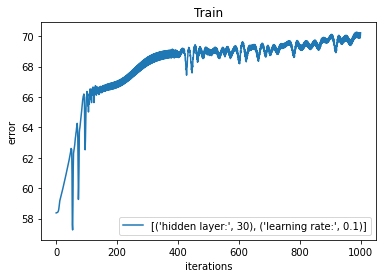

In [ ]:
plot_error(a_l_loss[2:], a_l_loss[0:2])

#### plot for 20 hidden neurons

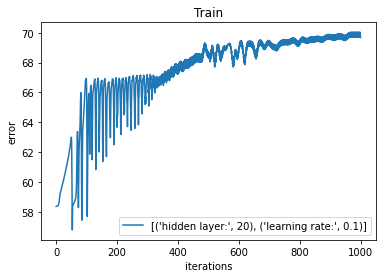

In [ ]:
plot_error(b_l_loss[2:], b_l_loss[:2])

#### plot for 10 hidden neurons

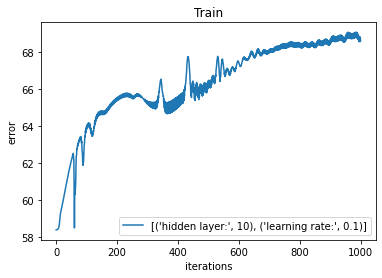

In [ ]:
plot_error(c_l_loss[2:], c_l_loss[:2])

## Step 5 - Compressing and Decompressing

Compressing the test set images using the NN trained before

In [ ]:
def compress(data, parameters):
  data = data.T
  W1 = parameters["W1"]
  b1 = parameters["b1"]
  Z1 = np.dot(W1, data) + b1
  A1 = sigmoid(Z1)
  A1 = A1 * 256
  return A1

In [ ]:
def decompress(data, parameters):
  W2 = parameters["W2"]
  b2 = parameters["b2"]
  Z2 = np.dot(W2, data) + b2
  A2 = sigmoid(Z2)
  return A2.T

#### 30 neurons

In [ ]:
a_t_compress = compress(test_set, a_parameters)
a_t_compress = decompress(a_t_compress, a_parameters)

#### 20 neurons

In [ ]:
b_t_compress = compress(test_set, b_parameters)
b_t_compress = decompress(b_t_compress, b_parameters)

#### 10 neurons

In [ ]:
c_t_compress = compress(test_set, c_parameters)
c_t_compress = decompress(c_t_compress, c_parameters)

## Step 6 - PSNR on testset

#### 30 neurons

In [ ]:
avg_PSNR(a_t_compress, test_set)

56.574115152758814

#### 20 neurons

In [ ]:
avg_PSNR(b_t_compress, test_set)

57.04241495315655

#### 10 neurons

In [ ]:
avg_PSNR(c_t_compress, test_set)

55.08187760381253

## Step 7 - Blocks to Image

In [ ]:
def array2images(images, img_size):
  num = img_size ** 2 // images.shape[1] # 255^2 // 64 = 1024
  c = []
  for i in range(0, images.shape[0], num):
    a = images[i:i+num]
    b = chunks2image(a, img_size)
    # break
    c.append(b)
  return np.array(c)

In [ ]:
def chunks2image(images, img_size):
  n = int(math.sqrt(images.shape[1])) # 8
  m = img_size // n # 32
  c = np.zeros((n, 1))
  tiles = []
  itr = 0
  for i in range(images.shape[0]): # 1024
    itr += 1
    a = images[i].reshape(n, n) # (8, 8)
    a = a.T
    for j in range(n):
      c = np.c_[c, a[j]] 
    if itr == m:
      itr = 0
      tiles.append(np.delete(c, 0, 1))
      c = np.zeros((n, 1))
  
  tiles = np.array(tiles)
  new_img = tiles.reshape((tiles.shape[0]*tiles.shape[1]), tiles.shape[2])
  return new_img

In [ ]:
def plot_img(images):
  num_examples = images.shape[0]
  plt.figure(figsize=(20, 20))
  i = 1
  for j in range(images.shape[0]): 
    ax = plt.subplot(1, num_examples, i)
    i += 1
    ax.title.set_text(i)
    plt.imshow(images[j], cmap='gray')

## Step 8 - Plotting the images

### 8.0 - testset images

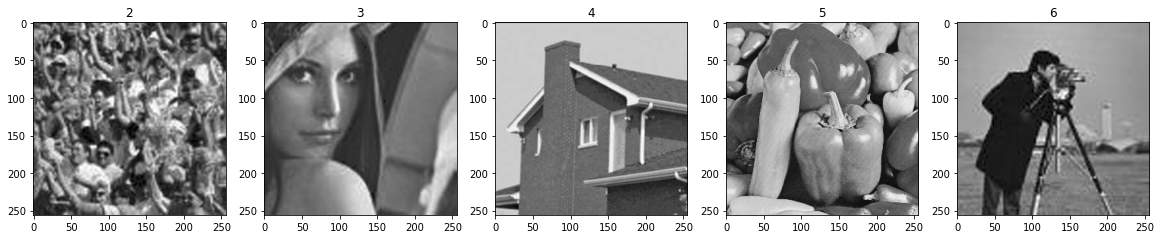

In [ ]:
jj = array2images(test_set, 256)
plot_img(jj)

### 8.1 - result of test set on trained MLP NN 

#### 30 neurons

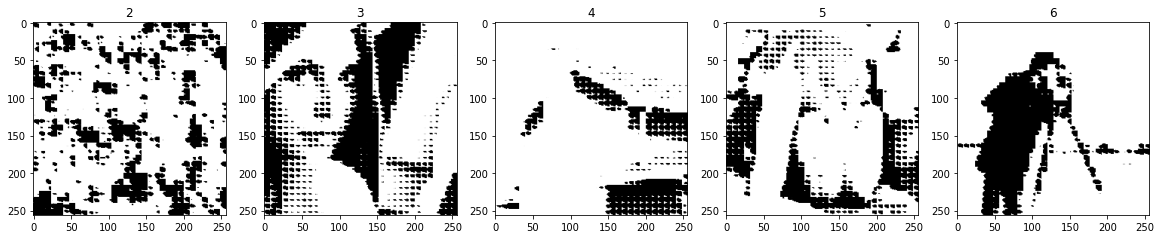

In [ ]:
tc_a = array2images(a_t_compress, 256)
plot_img(tc_a)

#### 20 neurons

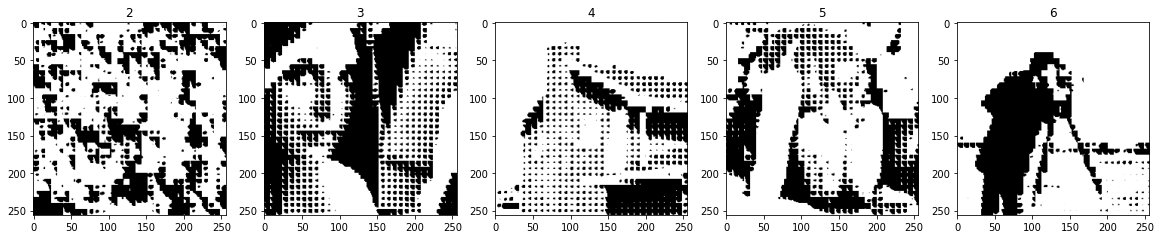

In [ ]:
tc_b = array2images(b_t_compress, 256)
plot_img(tc_b)

#### 10 neurons

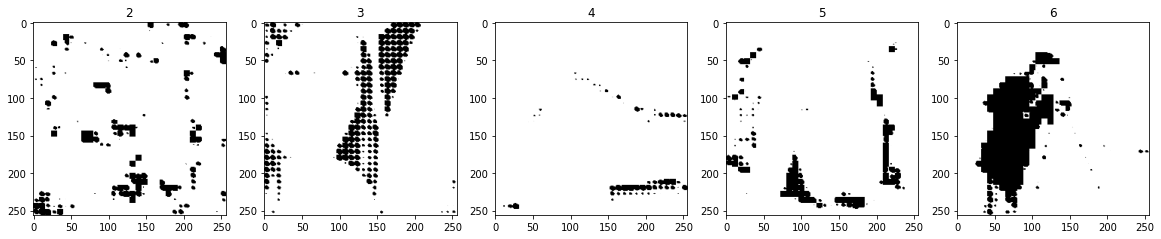

In [ ]:
tc_c = array2images(c_t_compress, 256)
plot_img(tc_c)